# Machine Learning Final Exam, Aug Semester, 2018

In this exam, you will demonstrate your understanding of the material from the lectures, tutorials, and problem sets.

For each question, insert your answer directly in this sheet. When complete, export the sheet as a PDF and upload to Gradescope.

Note that you have **2.5 hours** to do the exam. Also note that there are some short answer questions that you may be able to answer faster than the coding questions. You might consider answering those questions first to get as much credit as possible!

## Question 1 (10 points)

Generate 200 2D points from each of 3 Guassians with distributions shaped roughly as shown in the diagram below. Plot the resulting 600 points with different colors for each Gaussian.

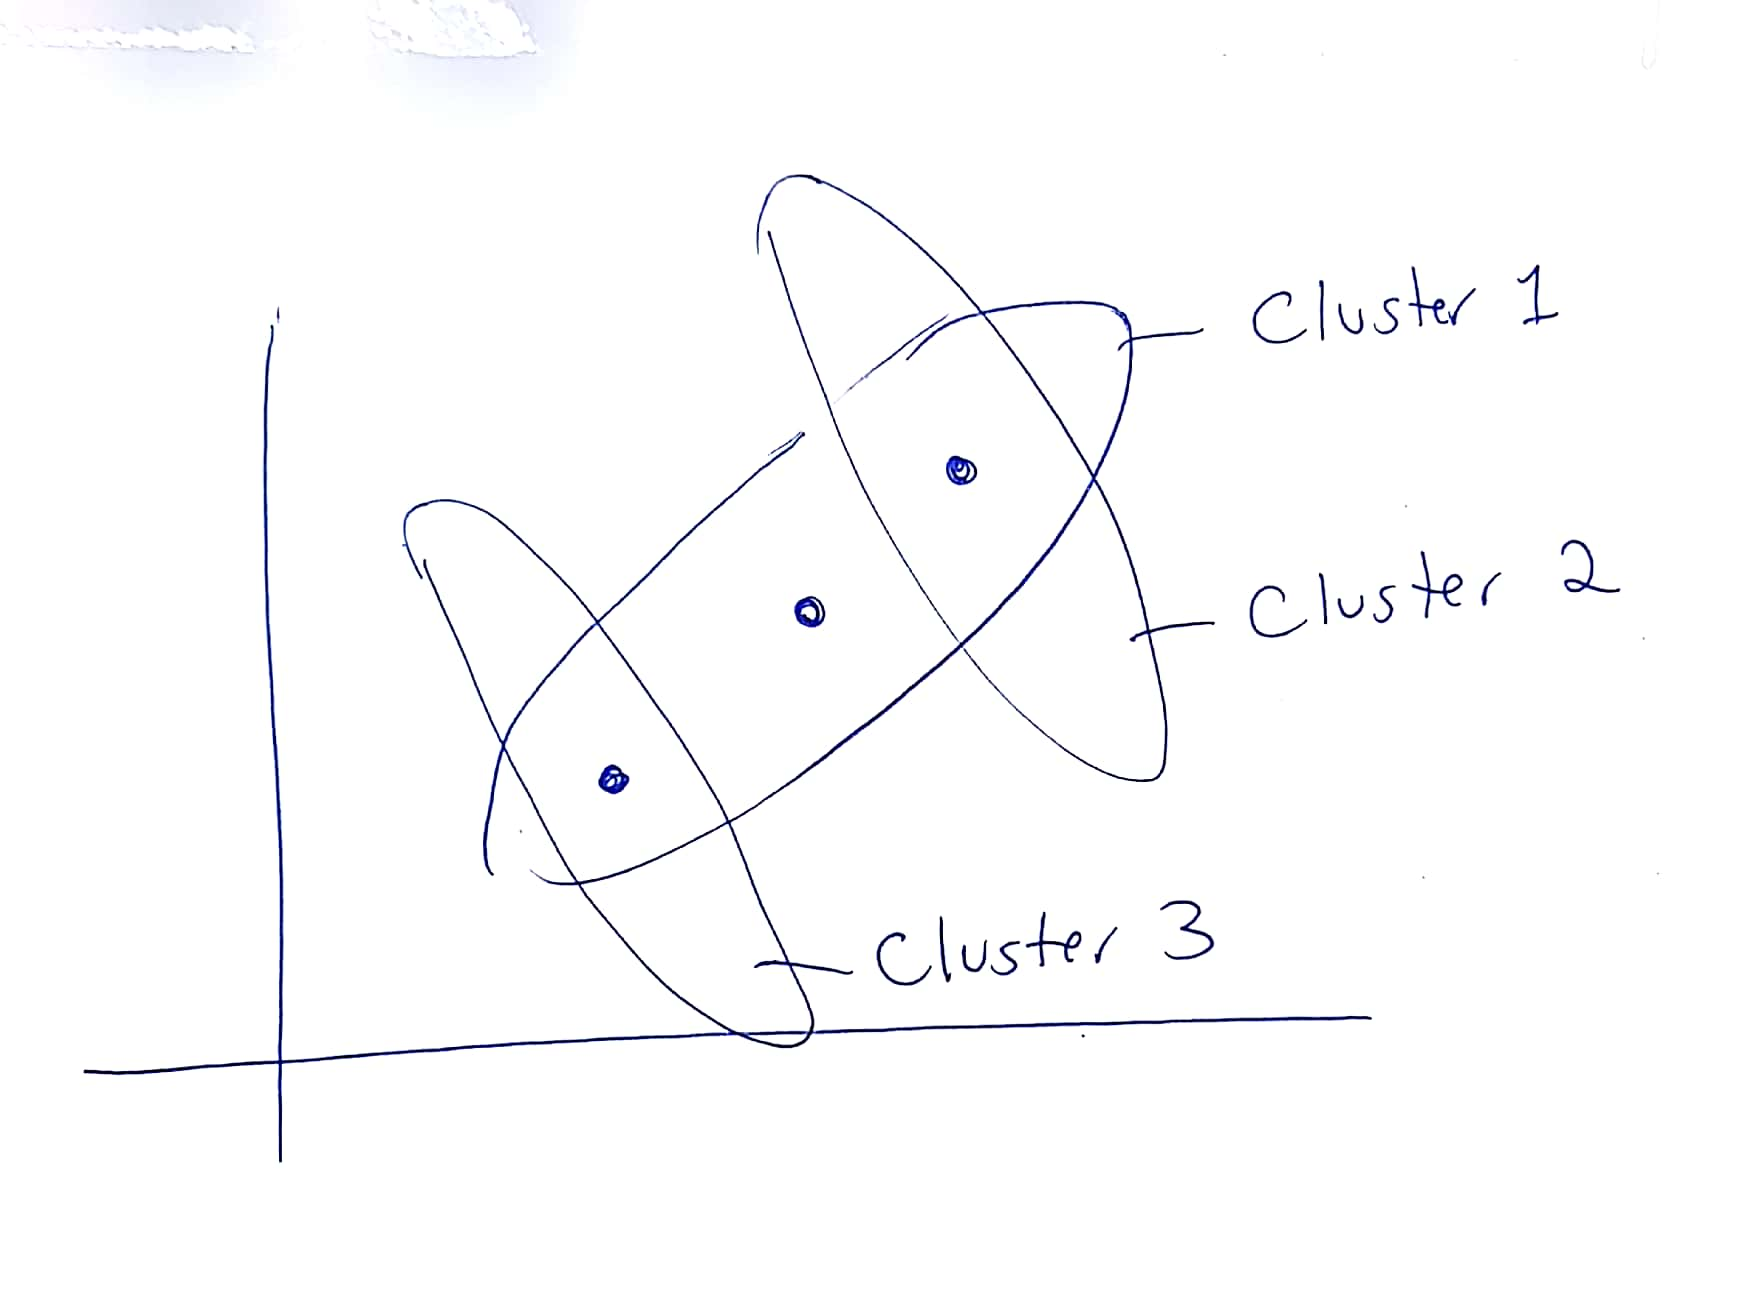


In [47]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

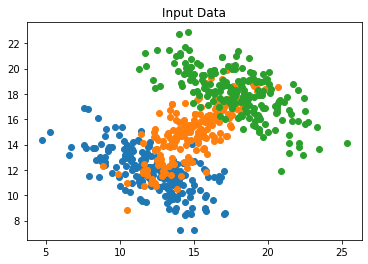

In [41]:
mu_1 = np.array([12,12])
mu_2 = np.array([15,15])
mu_3 = np.array([18,18])
sigma_1 = np.array([[6, -3], [-3, 3.5]])
sigma_2 = np.array([[4, 2.8], [2.8, 4]])
sigma_3 = np.array([[6, -3], [-3, 3.5]])
X1 = np.random.multivariate_normal(mu_1, sigma_1,200)
X2 = np.random.multivariate_normal(mu_2, sigma_2,200)
X3 = np.random.multivariate_normal(mu_3, sigma_3,200)
X = np.concatenate((X1,X2,X3),axis=0)

plt.scatter(X1[:,0],X1[:,1],cmap='red')
plt.scatter(X2[:,0],X2[:,1],cmap='green')
plt.scatter(X3[:,0],X3[:,1],cmap='blue')
plt.title("Input Data")
plt.show()

## Question 2 (10 points)

Fit a k-means model with k=3 to the data from Question 1. Plot the data with different colors indicating which cluster they are assigned to. Discuss whether it is a good model and why it is or is not good.

Iter 0 : distortion = 7.713923
Iter 10 : distortion = 6.714013
Iter 20 : distortion = 6.714013
Iter 30 : distortion = 6.714013
Iter 40 : distortion = 6.714013
Iter 50 : distortion = 6.714013
Iter 60 : distortion = 6.714013
Iter 70 : distortion = 6.714013
Iter 80 : distortion = 6.714013
Iter 90 : distortion = 6.714013


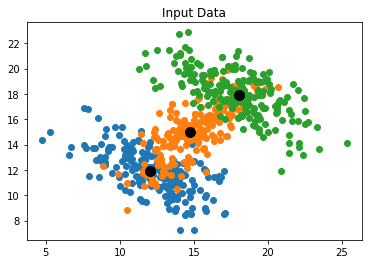

In [52]:
iters = 100
m,n = X.shape
k = 3 
indices = np.arange(m)
np.random.shuffle(indices)

#1. Initialize means
means = X[indices[0:3],:]
means

#2. Repeat until convergence

C = np.zeros(m,dtype=int)
for iter in range(iters):
    if iter == iters-1:
        plt.scatter(X1[:,0],X1[:,1],cmap='red')
        plt.scatter(X2[:,0],X2[:,1],cmap='green')
        plt.scatter(X3[:,0],X3[:,1],cmap='blue')
        plt.scatter(means[:,0],means[:,1],c ='black',s=100)
        plt.title('Input Data')
        plt.show()
    #2.1 map each datum to its nearest cluster center
    dist = 0
    for i in range(m):
        C[i] = np.argmin(np.linalg.norm(X[i,:]-means,axis=1))
        dist = dist + np.linalg.norm(X[i,:]-means[C[i],:])**2
    dist = dist/m
    if iter % 10 == 0:
        print('Iter %d : distortion = %f' % (iter,dist))
    
    #2.2 adjust means
    for j in range(k):
        means[j,:]=np.mean(X[C==j],axis=0)

Discuss whether it is a good model and why it is or is not good.


## Question 3 (20 points)

Fit a GMM with k=3 to the data from Question 1. Plot the data with different colors indicating which Gaussian component they are assigned to. Discuss whether it is a good model and why it is or is not good, in comparison to the k-means model.

In [53]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

In [55]:
threshold = np.matrix(.01)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

print(converged, pj.shape, X_label.shape)

True (600,) (600, 3)


In [56]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]

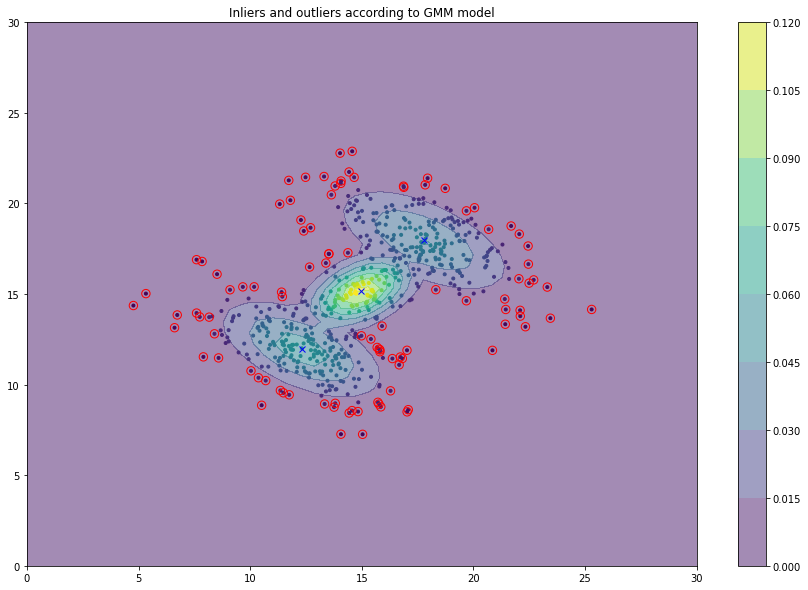

In [60]:
fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(0, 30, 50)
ylist = np.linspace(0, 30, 50)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
cbar = fig1.colorbar(cp)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()

## Question 4 (10 points)

Compare the Euclidean distortion for the 3 means learned by your k-means model in Question 2 and the 3 means learned by your GMM in Question 3. (By Euclidean distortion, we mean the sum squared Euclidean distance of the data points to their nearest means.) Which of the distortion values is lower?  Is the model with the lower Euclidean distortion the better model?  Why or why not?

## Question 5 (10 points)

Using the GMM model from Question 3, generate a LABELED dataset consisting of 200 points from each of the Gaussians, with the label of each point being the index of the Gaussian that generated it (1, 2, or 3).  Plot the data using different colors for the three components.

## Question 6 (30 points)

Split the data from Question 5 into a training set and validation set. Place 80% of the data in the training set and 20% of the data in the test set.  

Fit a neural network to the training data. The model should have a single hidden ReLU hidden layer and a 3-output softmax layer with cross entropy loss function.  

Build two models: one with a single unit in the hidden layer, and one with a sufficient number of units in the hidden layer to provide good classification results on both the training and validation sets. 

For the model with multiple hidden units, plot the loss on the training set and validation set as a function of training epoch.  

Analyze the loss curves: do you see evidence of overtraining?  If so, how should you deal with it? If not, why not, and how can you be sure you're obtaining the best possible results?

In [48]:
def partition(X, y, percent_train=0.8):
    m = y.shape[0]
    idx = np.arange(0,m)
    random.seed(1412)
    random.shuffle(idx)
    m_train = int(m * percent_train)
    train_idx = idx[:m_train]
    test_idx = idx[m_train:]
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]
    return X_train, y_train.reshape(-1,1), X_test, y_test.reshape(-1,1)

In [ ]:
data = np.array(data)
X = data[:,:-1]
y = data[:,-1]
X.shape,y.shape

## Question 7 (10 points)

Dicuss whether a linear SVM would be successful at accurately classifying the dataset you created in Question 5. Explain why it would or would not be successful If you think it would not be successful, suggest what type of SVM could accurately classify the dataset, and why it would.